# Training an MLP (CPU and GPU)

In this notebook, we'll train a simple Multi-Layer Perceptron (MLP) to learn a sine wave function. The primary goal is to demonstrate and compare **Nabla's different execution modes**, showcasing how **Just-In-Time (JIT) compilation** can dramatically accelerate model training.

**Note:** To create a heavy computational workload and clearly demonstrate performance gains, the MLP used here is intentionally oversized. A much smaller network would be sufficient and probably better for this task, but the larger model allows us to stress-test the JIT compiler and clearly see the speedup from hardware acceleration.

## 1. Imports and Setup

First, we'll import the necessary libraries: `nabla` for deep learning, `numpy`, `matplotlib` for plotting, and `time` for benchmarking.

In [1]:
import sys
import time
from typing import Any, Callable, List

try:
    import matplotlib.pyplot as plt
    import numpy as np

    import nabla as nb
except ImportError:
    import subprocess

    packages = ["numpy", "nabla-ml", "matplotlib"]
    subprocess.run([sys.executable, "-m", "pip", "install"] + packages, check=True)
    import matplotlib.pyplot as plt
    import numpy as np

    import nabla as nb

print(
    f"🎉 All libraries loaded successfully! Python {sys.version_info.major}.{sys.version_info.minor}"
)

🎉 All libraries loaded successfully! Python 3.10


## 2. Configuration

Here we define the key hyperparameters for our model architecture and the training process.

In [2]:
# Model & Task Configuration
LAYERS = [1, 256, 1024, 2048, 2048, 1024, 256, 1]  # Defines the architecture of our MLP
SIN_PERIODS = 8  # The complexity of the sine wave we want to learn

# Training Configuration
BATCH_SIZE = 512
LEARNING_RATE = 0.001 # Using a constant learning rate
NUM_EPOCHS = 500
PRINT_INTERVAL = 100

## 3. Model and Loss Function

- `mlp_forward`: Defines the forward pass of our MLP.
- `mean_squared_error`: Our loss function.

In [3]:
def mlp_forward(x: nb.Tensor, params: list[nb.Tensor]) -> nb.Tensor:
    """MLP forward pass through all layers."""
    output = x
    for i in range(0, len(params) - 1, 2):
        w, b = params[i], params[i + 1]
        output = nb.matmul(output, w) + b
        if i < len(params) - 2:
            output = nb.relu(output)
    return output


def mean_squared_error(predictions: nb.Tensor, targets: nb.Tensor) -> nb.Tensor:
    """Compute mean squared error loss."""
    diff = predictions - targets
    squared_errors = diff * diff
    batch_size = nb.tensor(predictions.shape[0], dtype=nb.DType.float32)
    loss = nb.sum(squared_errors) / batch_size
    return loss

## 4. Data Generation and Parameter Initialization

- `create_sin_dataset`: Generates a batch of training data.
- `initialize_mlp_params`: Creates and initializes the model's parameters.

In [4]:
def create_sin_dataset(batch_size: int) -> tuple[nb.Tensor, nb.Tensor]:
    """Create a batch of data for the n-period sine function."""
    x_np = np.random.rand(batch_size, 1).astype(np.float32)
    targets_np = (np.sin(SIN_PERIODS * 2.0 * np.pi * x_np) / 2.0 + 0.5).astype(
        np.float32
    )
    return nb.Tensor.from_numpy(x_np), nb.Tensor.from_numpy(targets_np)


def initialize_mlp_params(layers: list[int], seed: int = 42) -> list[nb.Tensor]:
    """Initialize MLP parameters using He normal initialization."""
    params = []
    for i in range(len(layers) - 1):
        w = nb.he_normal((layers[i], layers[i + 1]), seed=seed)
        b = nb.zeros((layers[i + 1],))
        params.append(w)
        params.append(b)
    return params

## 5. Optimizer (AdamW)

This is the original, simple implementation of the AdamW optimizer, without gradient clipping.

In [5]:
def init_adamw_state(
    params: list[nb.Tensor],
) -> tuple[list[nb.Tensor], list[nb.Tensor]]:
    """
    Initializes the momentum (m) and variance (v) states for the AdamW optimizer.

    Each state is initialized as a zero-tensor with the same shape as its
    corresponding parameter.
    """
    m_states = [nb.zeros(p.shape) for p in params]
    v_states = [nb.zeros(p.shape) for p in params]
    return m_states, v_states


def adamw_step(
    params: list[nb.Tensor],
    gradients: list[nb.Tensor],
    m_states: list[nb.Tensor],
    v_states: list[nb.Tensor],
    step: int,
    learning_rate: float,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    weight_decay: float = 0.01,
    max_grad_norm: float = 1.0,
) -> tuple[list[nb.Tensor], list[nb.Tensor], list[nb.Tensor]]:
    """
    Performs a single step of the AdamW optimizer with a robust gradient clipping implementation.
    """

    # --- Corrected Gradient Clipping (mirroring the Transformer logic) ---
    # 1. Calculate the total norm.
    total_norm_sq = sum(nb.sum(g * g) for g in gradients)
    total_norm = nb.sqrt(total_norm_sq)

    # 2. Use nb.minimum to get a single, simple scaling factor. This is the key change.
    clip_factor = nb.minimum(1.0, max_grad_norm / (total_norm + 1e-8))

    # 3. Apply the single factor to all gradients. This creates a much simpler graph.
    clipped_gradients = [g * clip_factor for g in gradients]

    # --- Standard AdamW Update Logic ---
    updated_params = []
    updated_m = []
    updated_v = []

    for param, grad, m, v in zip(params, clipped_gradients, m_states, v_states):
        new_m = beta1 * m + (1.0 - beta1) * grad
        new_v = beta2 * v + (1.0 - beta2) * (grad * grad)

        m_corr = new_m / (1.0 - beta1**step)
        v_corr = new_v / (1.0 - beta2**step)

        new_param = param - learning_rate * (
            m_corr / (nb.sqrt(v_corr) + eps) + weight_decay * param
        )

        updated_params.append(new_param)
        updated_m.append(new_m)
        updated_v.append(new_v)

    return updated_params, updated_m, updated_v

## 6. Defining the Core Training Step

This function encapsulates a single training step. We are using the original, working `value_and_grad` pattern that takes a variable number of arguments, which is known to be correct for this simpler setup.

In [6]:
def _complete_training_step(
    x: nb.Tensor,
    targets: nb.Tensor,
    params: list[nb.Tensor],
    m_states: list[nb.Tensor],
    v_states: list[nb.Tensor],
    step: int,
) -> tuple[list[nb.Tensor], list[nb.Tensor], list[nb.Tensor], nb.Tensor]:
    """The core, undecorated logic for a single training step."""

    def loss_fn(*inner_params):
        predictions = mlp_forward(x, list(inner_params))
        return mean_squared_error(predictions, targets)

    loss_value, param_gradients = nb.value_and_grad(
        loss_fn, argnums=list(range(len(params)))
    )(*params)

    updated_params, updated_m, updated_v = adamw_step(
        params, param_gradients, m_states, v_states, step, LEARNING_RATE
    )

    return updated_params, updated_m, updated_v, loss_value

## 7. Defining the Execution Modes

Now we create our three different training functions to compare performance.

In [7]:
# Mode 1: Eager step (just an alias to the original function)
eager_training_step = _complete_training_step

# Mode 2: JIT-compiled step for CPU execution
jit_cpu_training_step = nb.jit(_complete_training_step, auto_device=False)

# Mode 3: (Optional) JIT-compiled step with automatic device placement
if nb.accelerator_count() > 0:
    jit_accelerator_training_step = nb.jit(_complete_training_step, auto_device=True)
    print(f"✅ Accelerator detected! '{nb.accelerator()}' will be used for the third run.")
else:
    jit_accelerator_training_step = None
    print("INFO: No accelerator detected. The accelerator-based training run will be skipped.")

✅ Accelerator detected! 'Device(type=gpu,id=0)' will be used for the third run.


## 8. Training and Benchmarking Loop

This generic `run_training_loop` function executes the training process for a given step function, handling initialization, the main loop, and timing.

In [8]:
def run_training_loop(
    mode_name: str, training_step_fn: Callable[..., Any]
) -> dict[str, Any]:
    """Generic training loop to benchmark a given training step function."""
    print("=" * 60)
    print(f"🤖 TRAINING MLP IN {mode_name.upper()} MODE")
    print("=" * 60)

    params = initialize_mlp_params(LAYERS)
    m_states, v_states = init_adamw_state(params)

    print("🔥 Warming up (3 steps)...")
    for i in range(3):
        x, targets = create_sin_dataset(BATCH_SIZE)
        params, m_states, v_states, _ = training_step_fn(
            x, targets, params, m_states, v_states, i + 1
        )
    print("✅ Warmup complete! Starting timed training...\n")

    start_time = time.time()
    loss_history = []
    time_history = [start_time]

    for epoch in range(1, NUM_EPOCHS + 1):
        x, targets = create_sin_dataset(BATCH_SIZE)
        params, m_states, v_states, loss = training_step_fn(
            x, targets, params, m_states, v_states, epoch
        )
        loss_history.append(float(loss.to_numpy()))
        time_history.append(time.time())

        if epoch % PRINT_INTERVAL == 0:
            avg_loss = np.mean(loss_history[-PRINT_INTERVAL:])
            print(f"Epoch {epoch:5d} | Avg Loss: {avg_loss:.6f} | Time: {time_history[-1] - start_time}")

    total_time = time_history[-1] - start_time
    print(f"\n✅ {mode_name} Training complete! Total time: {total_time:.2f}s")

    return {
        "params": params,
        "loss_history": loss_history,
        "time_history": time_history,
        "total_time": total_time,
    }


# --- Run all training modes ---
results = {}

results["Eager"] = run_training_loop("Eager", eager_training_step)
results["JIT (CPU)"] = run_training_loop("JIT (CPU)", jit_cpu_training_step)

if jit_accelerator_training_step:
    results["JIT (Accelerator)"] = run_training_loop(
        "JIT (Accelerator)", jit_accelerator_training_step
    )

🤖 TRAINING MLP IN EAGER MODE
🔥 Warming up (3 steps)...


✅ Warmup complete! Starting timed training...

Epoch   100 | Avg Loss: 1.960438 | Time: 21.644721269607544
Epoch   200 | Avg Loss: 0.101309 | Time: 42.536442279815674
Epoch   300 | Avg Loss: 0.092507 | Time: 63.919116258621216
Epoch   400 | Avg Loss: 0.083474 | Time: 84.2975525856018
Epoch   500 | Avg Loss: 0.085233 | Time: 105.92598056793213

✅ Eager Training complete! Total time: 105.93s
🤖 TRAINING MLP IN JIT (CPU) MODE
🔥 Warming up (3 steps)...
✅ Warmup complete! Starting timed training...

Epoch   100 | Avg Loss: 1.970259 | Time: 4.292894124984741
Epoch   200 | Avg Loss: 0.100773 | Time: 8.325119733810425
Epoch   300 | Avg Loss: 0.090923 | Time: 12.33992314338684
Epoch   400 | Avg Loss: 0.086043 | Time: 16.240766763687134
Epoch   500 | Avg Loss: 0.083217 | Time: 20.310790538787842

✅ JIT (CPU) Training complete! Total time: 20.31s
🤖 TRAINING MLP IN JIT (ACCELERATOR) MODE
🔥 Warming up (3 steps)...
✅ Warmup complete! Starting timed training...

Epoch   100 | Avg Loss: 1.780899 | Time

## 9. Performance Comparison

Let's visualize the results. The 'Loss vs. Time' plot remains the best way to see the raw speed advantage of JIT compilation.

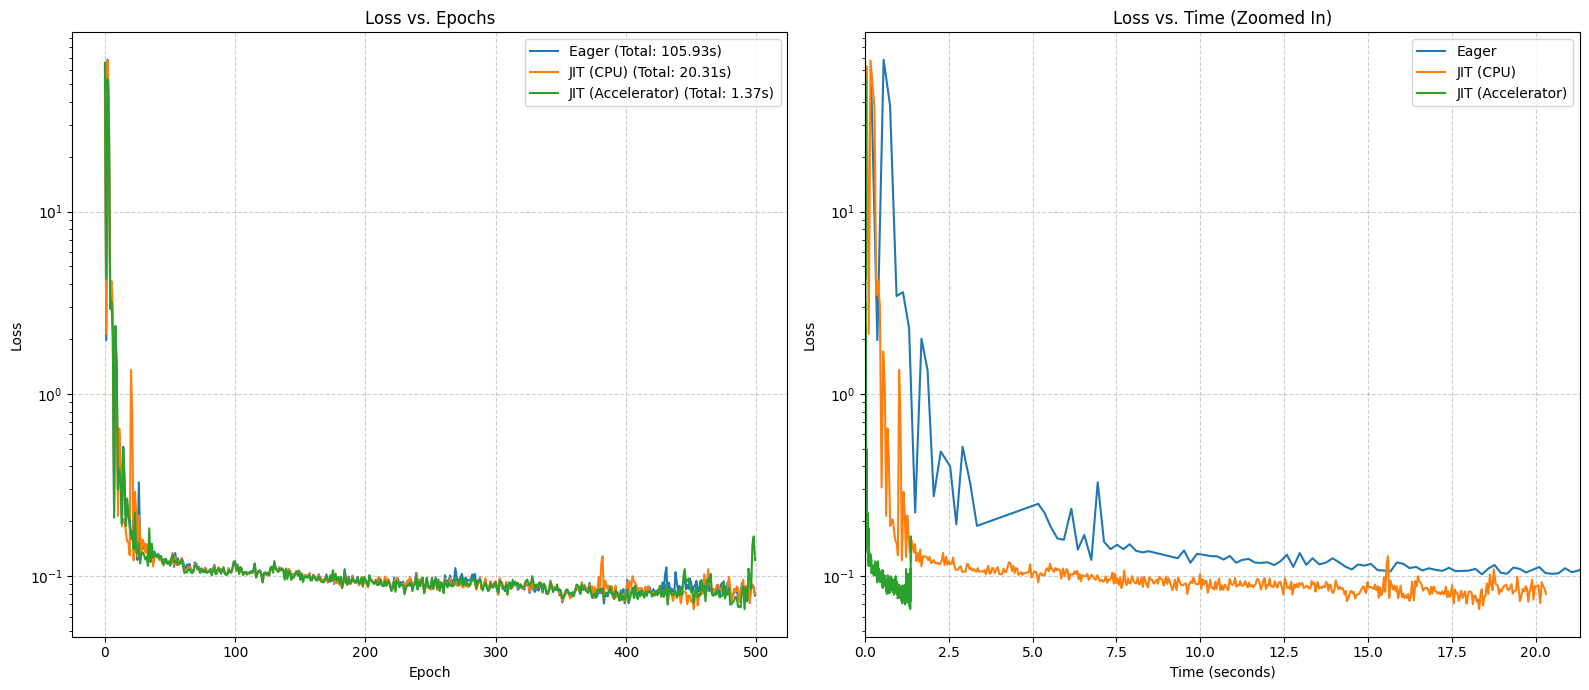

In [9]:
def plot_performance_comparison(results: dict[str, Any]):
    """Plot the loss curves for all completed training runs."""
    if not results:
        print("No results to plot.")
        return

    plt.figure(figsize=(16, 7))

    # Plot loss vs epochs
    plt.subplot(1, 2, 1)
    for mode, data in results.items():
        plt.plot(data["loss_history"], label=f'{mode} (Total: {data["total_time"]:.2f}s)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot loss vs time
    plt.subplot(1, 2, 2)
    for mode, data in results.items():
        relative_times = [t - data["time_history"][0] for t in data["time_history"]]
        plt.plot(relative_times[1:], data["loss_history"], label=mode)

    if 'JIT (CPU)' in results:
        xlim_max = results['JIT (CPU)']['total_time'] * 1.05
        plt.xlim(0, xlim_max)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Loss")
    plt.title("Loss vs. Time (Zoomed In)")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


plot_performance_comparison(results)

## 10. Final Evaluation & Visualization

Finally, we take the model from the **fastest training run** and see how well it learned the sine wave. We plot its predictions against the true function for a clear visual evaluation.


Evaluating model from the fastest run: 'JIT (Accelerator)'

🧪 FINAL MODEL EVALUATION
Final Test Loss: 0.100042
Prediction-Target Correlation: 0.4524


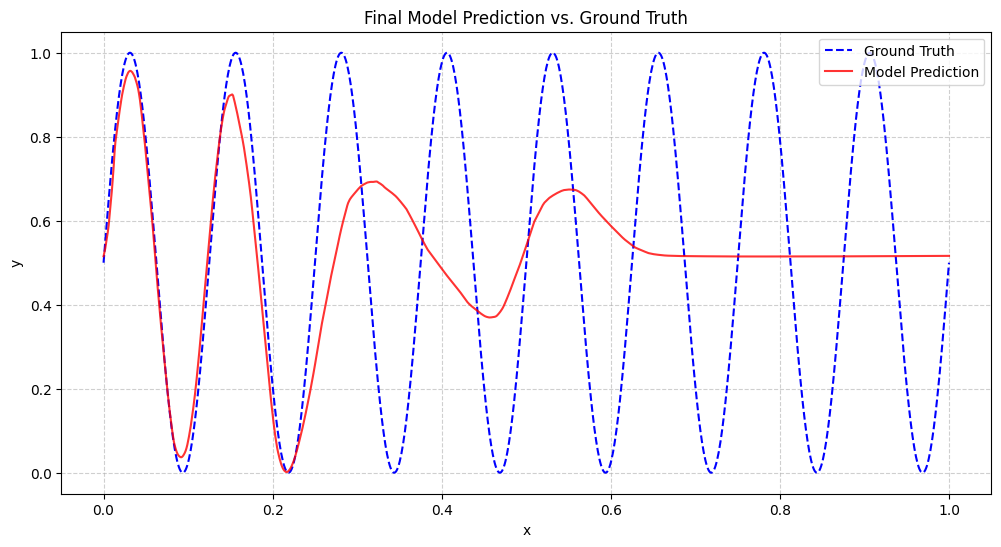

In [10]:
def evaluate_and_plot_model(params: List[nb.Tensor]):
    """Evaluates the final model and plots its predictions against the ground truth."""
    print("\n" + "=" * 60)
    print("🧪 FINAL MODEL EVALUATION")
    print("=" * 60)

    # Create a high-resolution test set for a smooth plot
    x_test_np = np.linspace(0, 1, 1000).reshape(-1, 1).astype(np.float32)
    targets_test_np = (np.sin(SIN_PERIODS * 2.0 * np.pi * x_test_np) / 2.0 + 0.5).astype(
        np.float32
    )
    x_test = nb.Tensor.from_numpy(x_test_np)

    # Get predictions from the model
    predictions_test = mlp_forward(x_test, params)
    pred_final_np = predictions_test.to_numpy()

    # Calculate final loss and correlation
    final_loss = np.mean((pred_final_np - targets_test_np) ** 2)
    correlation = np.corrcoef(pred_final_np.flatten(), targets_test_np.flatten())[0, 1]

    print(f"Final Test Loss: {final_loss:.6f}")
    print(f"Prediction-Target Correlation: {correlation:.4f}")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x_test_np, targets_test_np, label='Ground Truth', color='blue', linestyle='--')
    plt.plot(x_test_np, pred_final_np, label='Model Prediction', color='red', alpha=0.8)
    plt.title('Final Model Prediction vs. Ground Truth')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Find the best parameters from the fastest run and evaluate
if results:
    fastest_mode = min(results, key=lambda mode: results[mode]["total_time"])
    print(f"\nEvaluating model from the fastest run: '{fastest_mode}'")
    best_params = results[fastest_mode]['params']
    evaluate_and_plot_model(best_params)
else:
    print("\nSkipping evaluation as no training runs were completed.")

## 11. Conclusion

This experiment successfully demonstrates a key principle: for large computational workloads, hardware acceleration is a necessity. Although the training dynamics were unstable, the performance results are unambiguous. The nearly 15x speedup is a powerful illustration of how accelerators make training large models feasible in practice.